# Bivariate CMAP and Forloop 

*This notebook has been edited to look nicer than the original, despite the strict instructions NOT to. This is in everyone's best interest... particularly mine so that nobody sees how uneccessary long and complicated and undocumented my code is*

Enjoy the technical demo...

---

### Read in libraries and data

In [4]:
#!pip install xycmap

In [6]:
# Read libraries - nothing special
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import xycmap
import numpy as np
import osmnx
from shapely.geometry import Polygon
from tqdm import tqdm
import time
from tqdm.notebook import tqdm_notebook

In [8]:
# Read in data for technical demo - Part 1
part_1_df = pd.read_csv("../../Chicago/random_int_and_slope_with_loc_phase_two.csv")
part_1_gdf = gpd.GeoDataFrame(part_1_df, geometry=gpd.points_from_xy(part_1_df.Long, part_1_df.Lat))
part_1_gdf.head()

Unnamed: 0          stationame  (Intercept)   n_month       Long  \
0           0                18th     8.287564  0.384431 -87.669147   
1           2  35-Bronzeville-IIT    -1.305209  0.776573 -87.625826   
2           4         35th/Archer    -0.934090  0.392645 -87.680622   
3           6                43rd     3.213276 -0.815471 -87.619021   
4           8       47th-Dan Ryan     5.815754 -0.764998 -87.630940   

         Lat                    geometry  
0  41.857908  POINT (-87.66915 41.85791)  
1  41.831677  POINT (-87.62583 41.83168)  
2  41.829353  POINT (-87.68062 41.82935)  
3  41.816462  POINT (-87.61902 41.81646)  
4  41.810318  POINT (-87.63094 41.81032)

In [ ]:
# Read in Data for part 2 - forloop

---

# Part 1 - Bivariate CMAP

**Context:** I want to colour the points based on two variables: random intercept (`(Intercept)`) and random slope (`n_month`). 

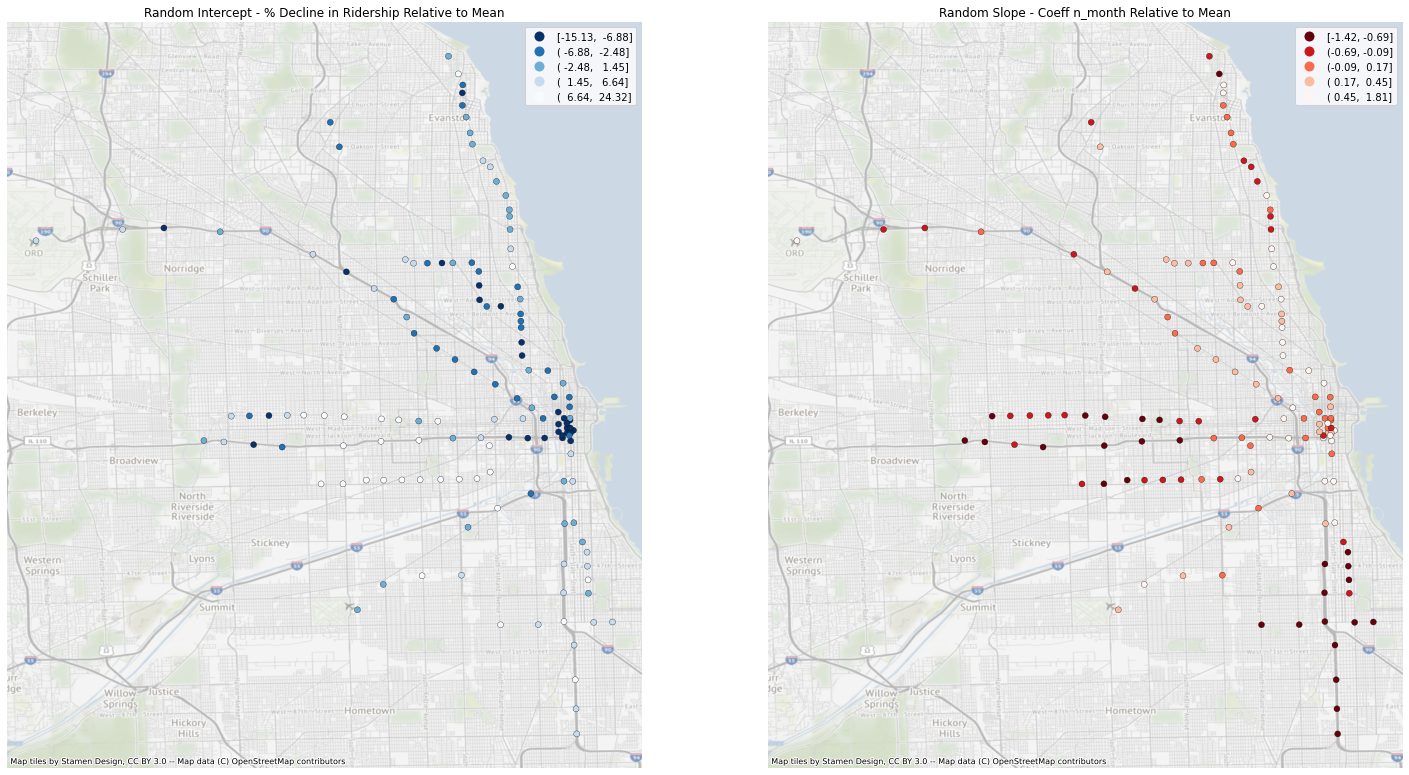

In [9]:
# Create plots which colour the points based on the two variables of interest - random intercept and slope

# Set up fig and axes
f, ax = plt.subplots(1, 2, figsize=(25,15))

# Plot each station and colour by random intercept value
part_1_gdf.plot(ax=ax[0], column=("(Intercept)"), scheme='quantiles', legend = True, cmap='Blues_r', edgecolors='black', linewidth=0.3)
cx.add_basemap(ax=ax[0], crs = "EPSG:4326", alpha=0.5) # Add basemap
ax[0].set_axis_off() # Hide axes
ax[0].set_title("Random Intercept - % Decline in Ridership Relative to Mean") # Set title

# plot each station and colour bu random slope
part_1_gdf.plot(ax=ax[1], column=("n_month"), scheme='quantiles', legend = True, cmap='Reds_r', edgecolors='black', linewidth=0.3)
cx.add_basemap(ax=ax[1], crs = "EPSG:4326", alpha=0.5) # Add basemap
ax[1].set_axis_off() # Hide axes
ax[1].set_title("Random Slope - Coeff n_month Relative to Mean"); # Add title

*Figure 1: Initial % change in ridership (a) and rate of changeover time (b)*

Four different types of points in Figure 1:
* Least impcated by Covid and slower increase over time (southern stations in lower SES neighbourhoods) - (light blue & dark red)
* Least impacted by Covid with stronger increase in ridership over study period (the odd station in SW and Nothern stations) - (light blue & light red)
* Most impacted by Covid with slower increase over time (residential areas in NW) - (dark blue & dark red)
* Most imapcted by Covid with stronger increase in ridership over study period (Commercial zones in The Loop) - dark blue & light red)


[Bivariate CMAP](https://pypi.org/project/xycmap/)

Requirements to create custom CMAP: 
- `Corner_colors` = These are the colours which will be in each corner
- `n` = Dimensions of your CMAP grid - Number of breaks defined by x and y (n *x* n)

In [10]:
# requirements
corner_colors = ("lightblue", "green", "purple", "lightyellow")
n = (4, 4)

# Custom CMAP
cmap = xycmap.custom_xycmap(corner_colors=corner_colors, n=n)

# Apply CMAP to two series 
colors = xycmap.bivariate_color(sx=part_1_gdf['(Intercept)'], sy=part_1_gdf['n_month'], cmap=cmap)

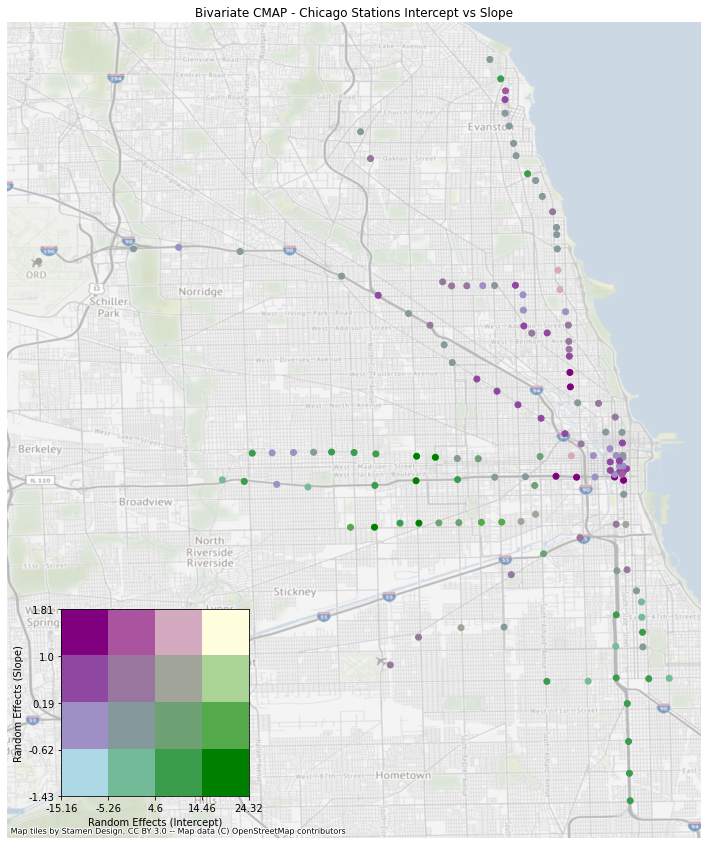

In [11]:
# Set up figure and axes
f, ax = plt.subplots(1, 1, figsize=(13, 15))

######################### Chicago Stations
part_1_gdf.plot(ax=ax, color=colors) # Plot Chic stations
ax.set_axis_off() # Hide axes
ax.set_title("Bivariate CMAP - Chicago Stations Intercept vs Slope") # Set title

######################## CMAP 
cax = f.add_axes([0.2, 0.15, 0.2, 0.2]) # Set position of legend
xycmap.bivariate_legend(ax=cax, sx=part_1_gdf['(Intercept)'], sy=part_1_gdf['n_month'], cmap=cmap) # Create legend
cax.set_ylabel('Random Effects (Slope)', rotation=90)
cax.set_xlabel('Random Effects (Intercept)')

####################### Basemap
cx.add_basemap(ax=ax, crs = "EPSG:4326", alpha=0.5) # Add basemap

### Interpretation:

**Green:** High intercept and low slope relative to the mean. Stations which were least impacted by Covid (typically lower socio-economic status neighbourhoods) and experience a lesser increase in ridership over time.

**Purple:** Low intercept and high slope relative to the mean. Stations which were most impacted by Covid (typically higher socio-economic status neighbourhoods and/or commercial areas) and a stronger increase in ridership over time 

### Pros ad Cons

**Pro:** Managed to represent stations based on two variables of interest 

**Con:** Difficult to distinguish how many stations belong in each section. 

**Possible Solution/Improvement:** Display the number of stations in each break in legend.

In [12]:
# create an array which has the number of sensors in each grid of the colormap
# Must be an easier way...
annot_list_np = np.array([
                          [len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= -5.26) & (part_1_gdf['n_month'] <= -0.62)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= 4.6) & (part_1_gdf['(Intercept)'] >= -5.26) & (part_1_gdf['n_month'] <= -0.62)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= 14.46) & (part_1_gdf['(Intercept)'] >= 4.6) & (part_1_gdf['n_month'] <= -0.62)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] >= 14.46) & (part_1_gdf['n_month'] <= -0.62)])],
                          [len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= -5.26) & (part_1_gdf['n_month'] <= 0.19) & (part_1_gdf['n_month'] >= -0.62)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= 4.6) & (part_1_gdf['(Intercept)'] >= -5.26) & (part_1_gdf['n_month'] <= 0.19) & (part_1_gdf['n_month'] >= -0.62)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= 14.46) & (part_1_gdf['(Intercept)'] >= 4.6) & (part_1_gdf['n_month'] <= 0.19) & (part_1_gdf['n_month'] >= -0.62)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] >= 14.46) & (part_1_gdf['n_month'] <= 0.19) & (part_1_gdf['n_month'] >= -0.62)])],
                          [len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= -5.26) & (part_1_gdf['n_month'] <= 1) & (part_1_gdf['n_month'] >= 0.19)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= 4.6) & (part_1_gdf['(Intercept)'] >= -5.26) & (part_1_gdf['n_month'] <= 1) & (part_1_gdf['n_month'] >= 0.19)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= 14.46) & (part_1_gdf['(Intercept)'] >= 4.6) & (part_1_gdf['n_month'] <= 1) & (part_1_gdf['n_month'] >= 0.19)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] >= 14.46) & (part_1_gdf['n_month'] <= 1) & (part_1_gdf['n_month'] >= 0.19)])],
                          [len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= -5.26) & (part_1_gdf['n_month'] >= 1)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= 4.6) & (part_1_gdf['(Intercept)'] >= -5.26) & (part_1_gdf['n_month'] >= 1)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] <= 14.46) & (part_1_gdf['(Intercept)'] >= 4.6) & (part_1_gdf['n_month'] >= 1)]),
                              len(part_1_gdf.loc[(part_1_gdf['(Intercept)'] >= 14.46) & (part_1_gdf['n_month'] >= 1)])]
                         ])
annot_list_np

array([[ 0,  7, 19,  5],
       [16, 31,  6,  3],
       [18, 19,  5,  0],
       [ 6,  2,  3,  0]])

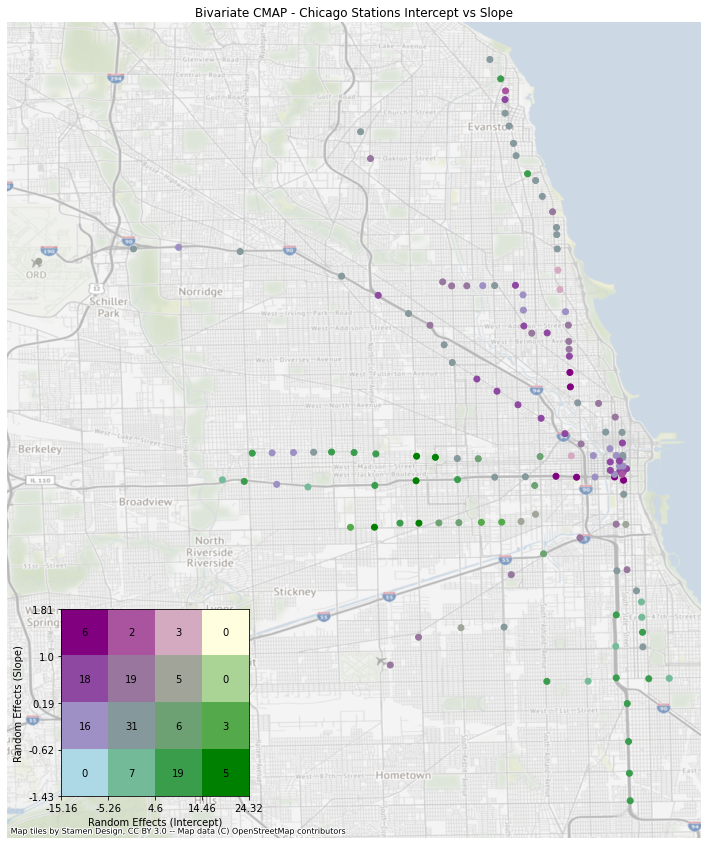

In [13]:
# Set up figure and axes
f, ax = plt.subplots(1, 1, figsize=(13, 15))

######################### Chicago Stations
part_1_gdf.plot(ax=ax, color=colors) # Plot Chic stations
ax.set_axis_off() # Hide axes
ax.set_title("Bivariate CMAP - Chicago Stations Intercept vs Slope") # Set title

######################## CMAP 
cax = f.add_axes([0.2, 0.15, 0.2, 0.2]) # Set position of legend
xycmap.bivariate_legend(ax=cax, sx=part_1_gdf['(Intercept)'], sy=part_1_gdf['n_month'], cmap=cmap) # Create legend
cax.set_ylabel('Random Effects (Slope)', rotation=90)
cax.set_xlabel('Random Effects (Intercept)')

# Annotate each section in legend with number of stations
for i in range(4):
    for j in range(4):
        text = cax.text(j, i, annot_list_np[i, j],
                       ha='center', va='center', color='black')

####################### Basemap
cx.add_basemap(ax=ax, crs = "EPSG:4326", alpha=0.5) # Add basemap

## Census Data

Bivariate colormas (*American spelling...*) are also useful for displaying categorical data - although I haven't figured out yet how to make it work because if you use categorical data (Male/Female, etc.), it doesn't like it, and there isn't much about the library online to find a solution. So to overcome this, I have created a binary variable and kept it as a numerical column raher than categorical.  

In [14]:
# read in census data from ENVS100
liv_census = gpd.read_file("../../../PHD/Demonstrating/ENVS100/P1/LiverpoolCensus-2/LiverpoolCensus.shp")
# Create new column whether area is younger or older (0 = Younger, 1 = Older)
liv_census['young_or_old'] = np.where(((liv_census['Age0to17'] > liv_census['Age65plus'])), 0, 1)

<AxesSubplot:>

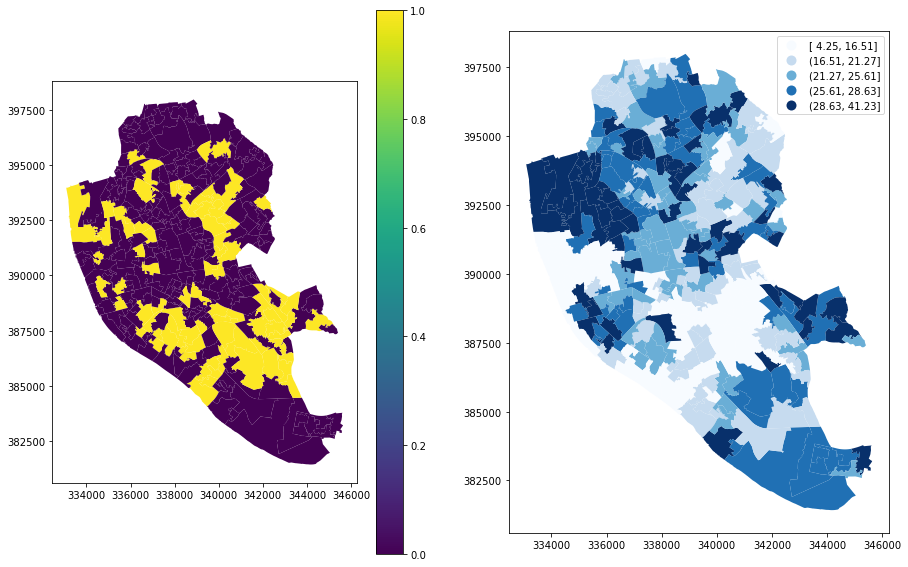

In [15]:
f, ax = plt.subplots(1, 2, figsize=(15, 10))

liv_census.plot(column='young_or_old', ax=ax[0], legend=True)
liv_census.plot(column='HealthbdPC', scheme='quantiles', ax=ax[1], legend=True, cmap='Blues')

In [16]:
# This colormap mixes two matplotlib colormaps
xcmap = plt.cm.rainbow
ycmap = plt.cm.Greys
n = (2, 5)  # x, y
cmap = xycmap.mean_xycmap(xcmap=xcmap, ycmap=ycmap, n=n)

In [17]:
# Apply CMAP to two series 
colors = xycmap.bivariate_color(sx=liv_census['young_or_old'], sy=liv_census['HealthbdPC'], cmap=cmap)

Text(0.5, 0, 'Young or Old')

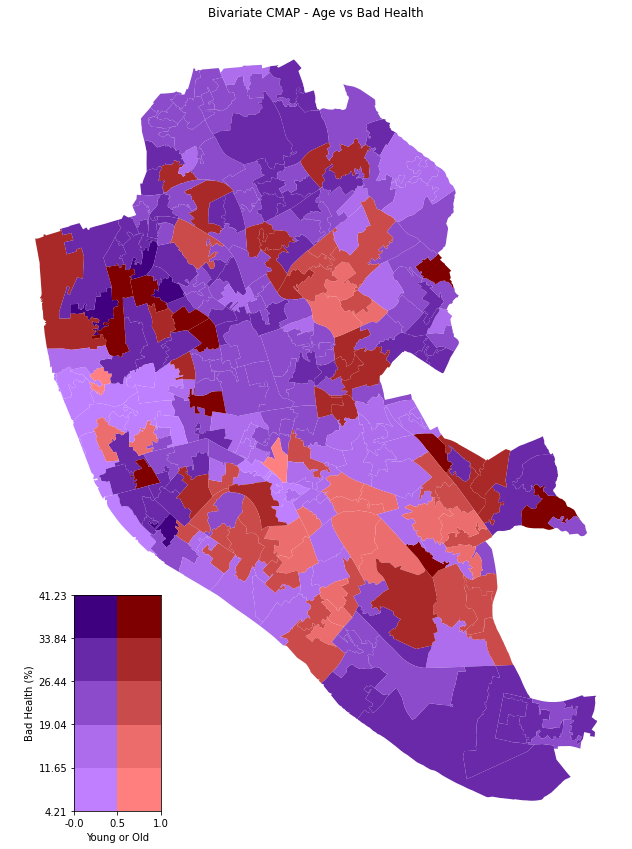

In [18]:
# Set up figure and axes
f, ax = plt.subplots(1, 1, figsize=(13, 15))

######################### Chicago Stations
liv_census.plot(ax=ax, color=colors) # Plot liv census shapefile
ax.set_axis_off() # Hide axes
ax.set_title("Bivariate CMAP - Age vs Bad Health") # Set title

######################## CMAP 
cax = f.add_axes([0.2, 0.15, 0.2, 0.2]) # Set position of legend
xycmap.bivariate_legend(ax=cax, sx=liv_census['young_or_old'], sy=liv_census['HealthbdPC'], cmap=cmap) # Create legend
cax.set_ylabel('Bad Health (%)', rotation=90)
cax.set_xlabel('Young or Old')

---

# Part 2 - For Loop for creating buffers using `OSMNX`

**Aim:** To create a function which would allow me to create multiple 800m walking buffers for each station in Chicago using `OSMNX` 

Tasks:
1. Create street network (nodes and edges) from Lat/Long point
1. Convert street network to GeoDataFrame
1. Create Convex Hull from GeoDataFrame
1. Convert Convex Hull to GeoDataFrame

In [19]:
##### The data
station_loc = pd.read_csv("../../Paper_3/Chicago/tables/station_location_with_coords.csv")
station_loc = station_loc.drop_duplicates(['MAP_ID'])
station_loc = gpd.GeoDataFrame(station_loc, geometry=gpd.points_from_xy(station_loc.Long, station_loc.Lat))
station_loc = station_loc.iloc[:, [1, 4, 6, -3, -2, -1]]
station_loc.head(2)

STOP_ID  STATION_NAME  MAP_ID        Lat       Long  \
0    30082        Cicero   40420  41.851820 -87.745336   
1    30151  Central Park   40780  41.853839 -87.714842   

                     geometry  
0  POINT (-87.74534 41.85182)  
1  POINT (-87.71484 41.85384)

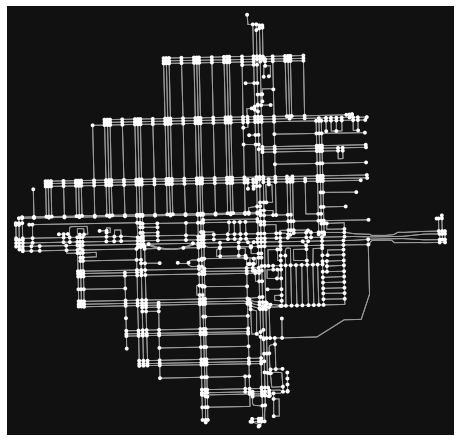

Wall time: 1min 9s


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [20]:
%%time
############################ STEP 1
# Print street network (nodes and edges) for a single point
G = osmnx.graph_from_point((41.851820, -87.745336), dist=800, dist_type='network', network_type='walk')
osmnx.plot_graph(G)

# Break 1:

**Resources in R:**

[Link 1](http://lenkiefer.com/2017/04/24/bivariate-map/) & [Link 2](https://cran.r-project.org/web/packages/biscale/vignettes/biscale.html)

In [21]:
%%time
################################ STEP 2
# Convert the graph above to gdf
G_gdf = osmnx.graph_to_gdfs(G, edges=False)

Wall time: 43.9 ms


Wall time: 16 ms


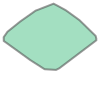

In [22]:
%%time
############################### STEP 3
hull = G_gdf.to_crs(epsg=4326).unary_union.convex_hull
hull

<AxesSubplot:>

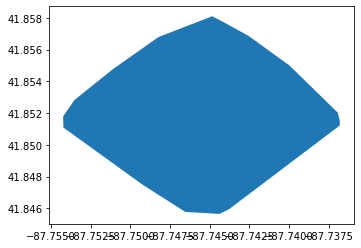

In [23]:
################################ STEP 4
hull_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(hull))
hull_gdf.plot()

Great, it works... But I'm not going to do this 140 times for each station

**Next:** A function which can do steps 1-4 for all station and append all station buffers in to one GeoDataFrame.

In [24]:
# Prepare data - must be Lat / Long Columns only
# Filter te data so that there is only Lat and Long columns
chic_stations_lat_long = station_loc.iloc[0:3 , 3:5]
chic_stations_lat_long.head()

Lat       Long
0  41.851820 -87.745336
1  41.853839 -87.714842
2  41.778943 -87.644244

In [ ]:
def station_bufer(data):
    func_gdf = gpd.GeoDataFrame(columns=['geometry']) # Initialise the empty GeoDataFrame
        G = osmnx.graph_from_point((data.iloc[i, 0], data.iloc[i, 1]), dist=800, dist_type='network', network_type='walk') # Get all nodes and edges within a 800m distance of each station/point
    G_gdf = osmnx.graph_to_gdfs(G, edges=False) # Convert the graph (specifically nodes) to GeoDataFrame - each row will consist of a Lat/Long for each individual node
    hull = G_gdf.to_crs(epsg=4269).unary_union.convex_hull # Create a convex hull from the nodes - a polygon/geometry which encloses all points 
    hull_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(hull)) # Convert this Polygon to a GeoDataFrame
    func_gdf = func_gdf.append(hull_gdf) # Append the geometry of each convex hull to the (originally) empty GeoDataFrame
return func_gdf

In [ ]:
list(map(lambda x: station_bufer(x), list

In [25]:
def station_bufer(data):
    func_gdf = gpd.GeoDataFrame(columns=['geometry']) # Initialise the empty GeoDataFrame
    for i in tqdm(range(len(data))): # Initialise the forloop which will repeat the following processes for each station - add progress bar from `tqdm` library
        G = osmnx.graph_from_point((data.iloc[i, 0], data.iloc[i, 1]), dist=800, dist_type='network', network_type='walk') # Get all nodes and edges within a 800m distance of each station/point
        G_gdf = osmnx.graph_to_gdfs(G, edges=False) # Convert the graph (specifically nodes) to GeoDataFrame - each row will consist of a Lat/Long for each individual node
        hull = G_gdf.to_crs(epsg=4269).unary_union.convex_hull # Create a convex hull from the nodes - a polygon/geometry which encloses all points 
        hull_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(hull)) # Convert this Polygon to a GeoDataFrame
        func_gdf = func_gdf.append(hull_gdf) # Append the geometry of each convex hull to the (originally) empty GeoDataFrame
    return func_gdf

In [26]:
# Use function on df to create convex hull for each station in Chicago
chic_buffers = station_bufer(chic_stations_lat_long)
chic_buffers = chic_buffers.set_crs(epsg=4269, inplace=True)
chic_buffers.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:44<00:00, 74.99s/it]


geometry
0  POLYGON ((-87.74438 41.84565, -87.74653 41.845...
0  POLYGON ((-87.71612 41.84770, -87.71734 41.848...
0  POLYGON ((-87.64521 41.77248, -87.64582 41.772...

# Break 2:

Either **discussion** on Bivariate CMAP - how would you use it / have you used it / how would you improve it / challenges

**or**

**Discussion** on forloops - have you used it / how have you used it / useful resources

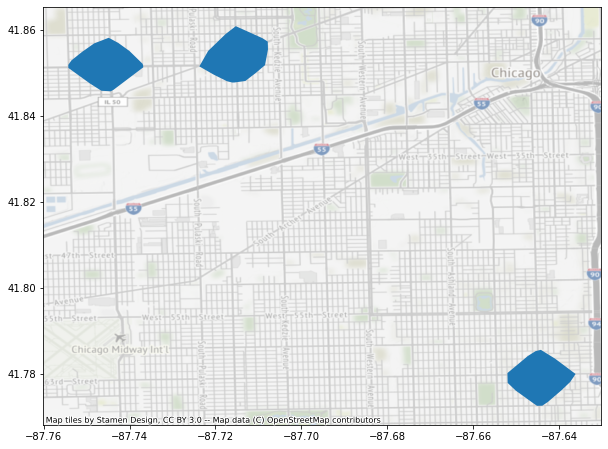

In [22]:
f, ax = plt.subplots(1, figsize=(10,10))

chic_buffers.plot(ax=ax)
cx.add_basemap(ax=ax, crs = "EPSG:4326", alpha=0.5) # Add basemap

---

### My logic

Make a simpler forloop in order to achieve what i finally wanted - creating this function took several hours to complete.

I create a basic function and incremetaly make it more complex until i achieve what i want

**Example:**

1. Create a function which would print the Latitude of all rows (wihtout forloop)
1. Create a function which would print out Latitude of all rows (with forloop) and append to list
1. Create a function which would append Latitude of all rows to DataFrame

In [23]:
# Prepare the data
chic_subset = station_loc.iloc[0:3, 3:5]
chic_subset

Lat       Long
0  41.851820 -87.745336
1  41.853839 -87.714842
2  41.778943 -87.644244

In [24]:
################# FUNCTION 1

#Practice creating a function and returns
def print_lat(data):
    T = data.iloc[0, 0]
    return T
    
ret = print_lat(chic_subset)
ret

41.851820000000004

In [25]:
################## FUNCTION 2

#Practice creating a function and returns with forloop
ret = []

def print_lat(data):
    for i in range(3):
        T = data.iloc[i, 0]
        ret.append(T)
    return ret
    
print_lat(chic_subset)

[41.851820000000004, 41.853839, 41.778943]

In [26]:
################### FUNCTION 3

#Practice creating a function and returns with forloop
ret_2 = pd.DataFrame(columns=['Lat'])

def print_lat(data):
    for i in range(3):
        T = data.iloc[i, 0]
        ret_2.loc[i] = T
    return ret_2
    
print_lat(chic_subset)

Lat
0  41.851820
1  41.853839
2  41.778943